# Import

In [1]:
%matplotlib inline

import os
import math
from pathlib import Path
from functools import partial
from inspect import isfunction

import cv2
import matplotlib
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from einops.layers.torch import Rearrange
from einops import rearrange, reduce, repeat
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import torch
import torchvision
from torch import nn, einsum
import torch.utils.data as data
import torch.nn.functional as F
from torchvision import transforms
from torch.cuda.amp import autocast
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize

from utils import *
from unet import Unet
from data_loader import make_data_loader

# Parameters

In [2]:
device = 'cuda'
image_size = 64
batch_size = 128

channels = 1
unet_dim = 32
num_classes = 26
num_style = 1000
timesteps = 1000
unet_dim_mults = (1, 2, 4, 8,)
# model_path = 'weight/log3_classifier_free_guidance_step_400000.pth'
# model_path = 'weight/log7_C26_S1000_cfg_step_final.pth'
# model_path = './weight/log12_C26_S1000_cfg_step_final.pth'
model_path = './weight/log13_C26_S1000_cfg_step_final.pth'

# define betas
betas = cosine_beta_schedule(timesteps=timesteps)

# define alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0) # alpha_var
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0) # [1. , *alphas_cumpprod[:-1]]
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
# 順方向の拡散過程
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod) # どのくらい元画像を残すか，徐々に小さくなる
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod) # どのくらいノイズを加えるか，徐々に大きくなる

# calculations for posterior q(x_{t-1} | x_t, x_0)
# 逆方向の拡散過程
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod) # sigma_t^2 どのくらいノイズを加えるか，徐々に小さくなる．非常に小さい

# forward diffusion (using the nice property)
@autocast(enabled = False)
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

@torch.no_grad()
def p_sample(model, x, classes, style, t, t_index, class_scale=6., style_scale=6., rescaled_phi=0.7):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    pred_noise = model.forward_with_cond_scale(x, t, classes, style, class_scale=class_scale, style_scale=style_scale, rescaled_phi=rescaled_phi)
    model_mean = sqrt_recip_alphas_t * (x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise

# Algorithm 2 (including returning all images)
@torch.no_grad()
def p_sample_loop(model, classes, style, shape, class_scale=6., style_scale=6., rescaled_phi=0.7):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, classes, style, torch.full((b,), i, device=device, dtype=torch.long), i, class_scale=class_scale, style_scale=style_scale, rescaled_phi=rescaled_phi)
    return img

@torch.no_grad()
def sample(model, classes, style, image_size, batch_size=16, channels=3, class_scale=6., style_scale=6., rescaled_phi=0.7):
    return p_sample_loop(model, classes, style, shape=(batch_size, channels, image_size, image_size), class_scale=class_scale, style_scale=style_scale, rescaled_phi=rescaled_phi)

def imscatter(x,y,image_list,_ax=None,zoom=0.2,color=['black']):
    for i in range(len(image_list)):
        if len(color) < len(image_list):
            color.append(color[0])
        if _ax is None:
            _ax = plt.gca()
        image = image_list[i] #plt.imread(image_list[i])
        im = OffsetImage(image,zoom=zoom)
        artists = []
        x0 = x[i]
        y0 = y[i]
        ab = AnnotationBbox(im,(x0,y0),xycoords='data',frameon=True,bboxprops=dict(color=color[i]))
        artists.append(_ax.add_artist(ab))
    return artists

# データの読み込み

In [3]:
dataloader = make_data_loader(batch_size, image_size, num_style)['train']
d = dataloader.dataset

TRAIN SIZE: 26000
TEST SIZE: 0


In [ ]:
i = 26*4 + 23
d = dataloader.dataset
plt.imshow(d[i][0][0], cmap='gray')
c = chr(d[i][1] + ord('A'))
print(c)
print('style:', d[i][2])
print(d[i][0][0].min(), d[i][0][0].max())

In [ ]:
max_i = 0
for _, _, i in d['train'].dataset:
    max_i = max(max_i, i)
print(max_i)

# Load trained model

In [3]:
model = Unet(
    dim=unet_dim,
    channels=channels,
    dim_mults=unet_dim_mults,
    num_classes=num_classes,
    num_style=num_style,
    cond_drop_prob=0.5,
)
model.to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print('ok')

ok


# 生成画像のL1

In [ ]:
with open('result/eval.txt', 'a') as f:
    f.write('\n============\n')
    f.write(f"{model_path.split('/')[-1]}\n")

for scale in [3., 5., 7.]:
    style_scale = scale
    class_scale = scale
    rescaled_phi = 0.7

    loss = nn.L1Loss()
    total_loss = 0.

    for gt, c, s in dataloader:
        gt = gt.to(device)
        c = c.to(device)
        s = s.to(device)
        output = sample(model, c, s, image_size=image_size, batch_size=gt.size(0), channels=channels,
                        class_scale=class_scale, style_scale=style_scale, rescaled_phi=rescaled_phi)

        total_loss += loss(output, gt).item() * gt.size(0)

    total_loss /= len(dataloader.dataset)

    with open('result/eval.txt', 'a') as f:
        f.write(f'\tscale: {scale}, l1 loss: {total_loss}\n')

# condition指定して生成

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

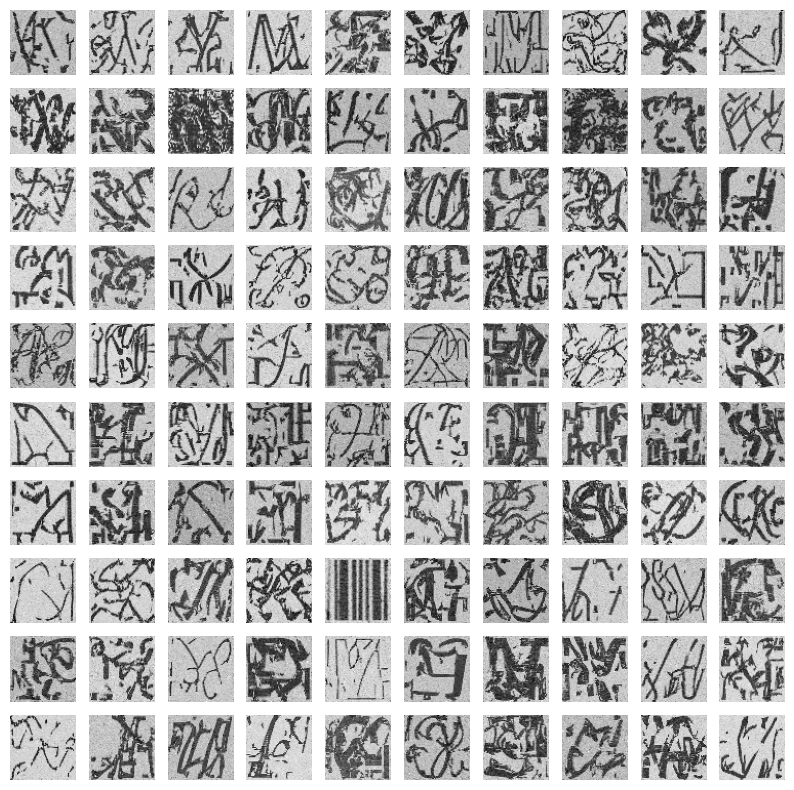

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

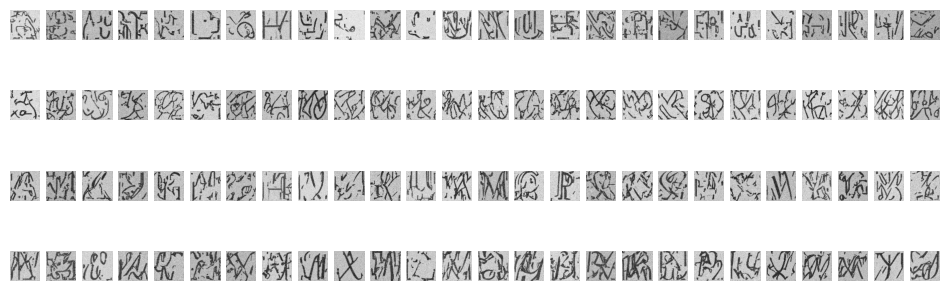

In [4]:
style_scale = 3.01
class_scale = 3.01
rescaled_phi = 0.7

# 様々なスタイルを見る
b = 100
classes = torch.full((b,), 0, device=device, dtype=torch.long)
style = torch.tensor([i for i in range(b)], device=device, dtype=torch.long)
samples = sample(model, classes, style, image_size=image_size, batch_size=b, channels=channels, class_scale=class_scale, style_scale=style_scale, rescaled_phi=rescaled_phi)

# show images
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(b):
    x = i // 10
    y = i % 10
    ax[x, y].axis("off")
    ax[x, y].imshow(samples[i][0].cpu().detach(), cmap="gray")

plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_generated1_{style_scale}_{class_scale}.png")
plt.show()

# 様々なクラスを見る
b = 26*4
classes = torch.tensor([i%26 for i in range(b)], device=device, dtype=torch.long)
style = torch.tensor([i//26 for i in range(b)], device=device, dtype=torch.long)
samples = sample(model, classes, style, image_size=image_size, batch_size=b, channels=channels, class_scale=class_scale, style_scale=style_scale, rescaled_phi=rescaled_phi)

# show images
fig, ax = plt.subplots(4, 26, figsize=(12, 4))
for i in range(b):
    x = i // 26
    y = i % 26
    ax[x, y].axis("off")
    ax[x, y].imshow(samples[i][0].cpu().detach(), cmap="gray")

plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_generated2_{style_scale}_{class_scale}.png")
plt.show()

# GT

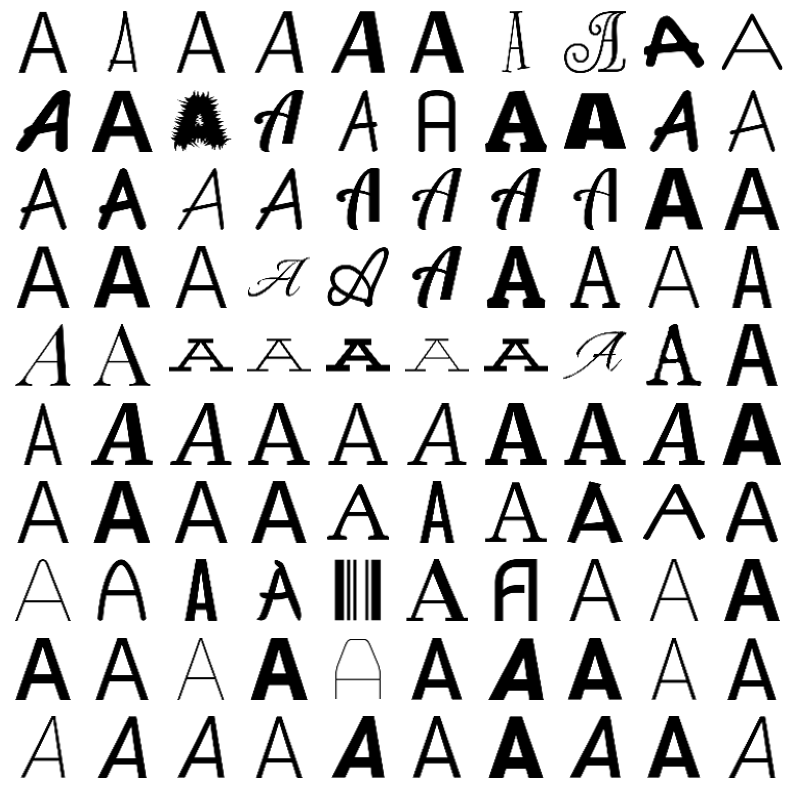

In [7]:
# 100フォント見る（上から100）
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(100):
    ax[i//10, i%10].axis('off')
    ax[i//10, i%10].imshow(d[26*i][0][0], cmap='gray')

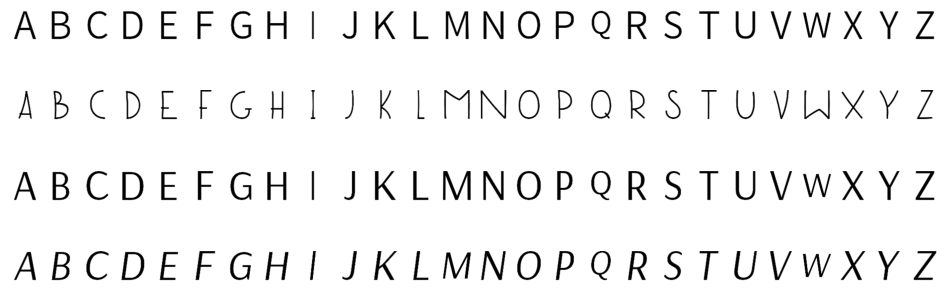

In [5]:
# 上から4フォント，A-Z
fig, ax = plt.subplots(4, 26, figsize=(12, 4))
for i in range(4*26):
    ax[i//26, i%26].axis('off')
    ax[i//26, i%26].imshow(d[i][0][0], cmap='gray')

# ノイズのインターポレーション

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

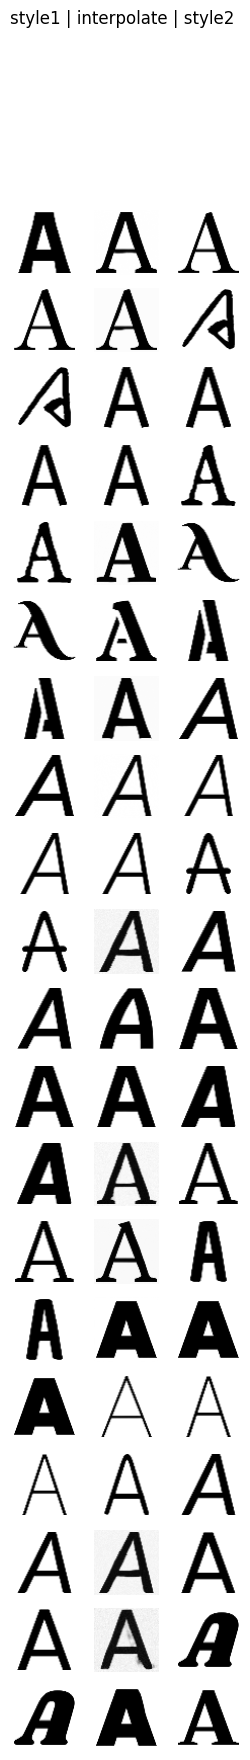

In [22]:
@torch.no_grad()
def p_sample_noise_interpolate(x, classes, style1, style2, t, t_index, class_scale=6., style_scale=6., rescaled_phi=0.7):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    pred_noise1 = model.forward_with_cond_scale(x, t, classes, style1, class_scale=class_scale, style_scale=style_scale, rescaled_phi=rescaled_phi)
    pred_noise2 = model.forward_with_cond_scale(x, t, classes, style2, class_scale=class_scale, style_scale=style_scale, rescaled_phi=rescaled_phi)
    alpha = 0.5
    pred_noise = alpha * pred_noise1 + (1 - alpha) * pred_noise2
    model_mean = sqrt_recip_alphas_t * (x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

style_scale = 3.
class_scale = 3.
rescaled_phi = 0.7

b = 20
img = torch.randn((b, channels, image_size, image_size), device=device)
classes = torch.full((b,), 0, device=device, dtype=torch.long)
style = torch.tensor([[i, (i+1)%num_style] for i in range(b)], device=device, dtype=torch.long)

for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
    img = p_sample_noise_interpolate(img, classes, style[:, 0], style[:, 1], torch.full((b,), i, device=device, dtype=torch.long), i,
                    class_scale=class_scale, style_scale=style_scale, rescaled_phi=rescaled_phi)

fig, ax = plt.subplots(b, 3, figsize=(3, b))
for i in range(b):
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
    ax[i, 2].axis('off')
    ax[i, 0].imshow(d[26*style[i][0]][0][0], cmap='gray')
    ax[i, 1].imshow(img[i][0].cpu().detach().clone(), cmap='gray')
    ax[i, 2].imshow(d[26*style[i][1]][0][0], cmap='gray')
fig.suptitle('style1 | interpolate | style2')
plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_noise_interpolate_{style_scale}_{class_scale}.png")

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

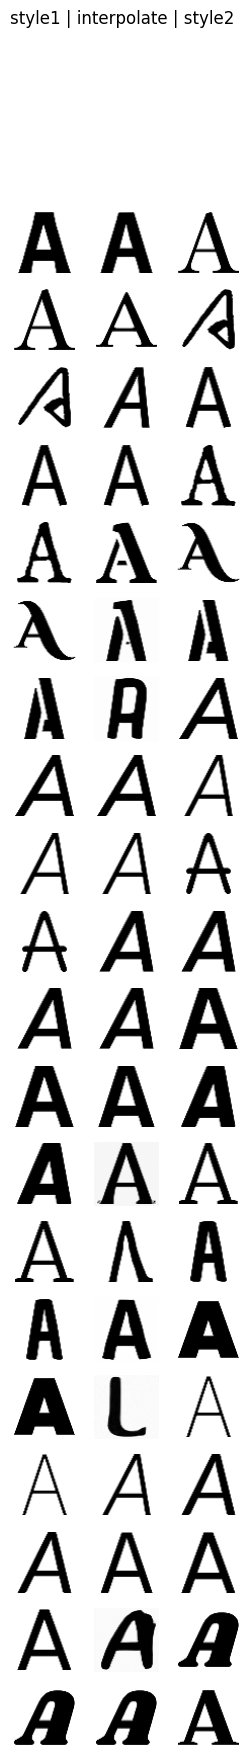

In [11]:
@torch.no_grad()
def p_sample_interpolate(x, classes, style1, style2, t, t_index, class_scale=6., style_scale=6., rescaled_phi=0.7):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    style1_noise = model(x, t, classes, style1, class_drop_prob=0., style_drop_prob=0.)
    style2_noise = model(x, t, classes, style2, class_drop_prob=0., style_drop_prob=0.)
    style_null_noise = model(x, t, classes, style1, class_drop_prob=0., style_drop_prob=1.)

    alpha = 0.5
    scaled_noise = style_scale * (alpha*(style1_noise - style_null_noise) + (1-alpha)*(style2_noise - style_null_noise)) + style_null_noise

    std_fn = partial(torch.std, dim = tuple(range(1, scaled_noise.ndim)), keepdim = True)
    rescaled_noise = scaled_noise * (std_fn(style_null_noise) / std_fn(scaled_noise))

    model_mean = sqrt_recip_alphas_t * (x - betas_t * rescaled_noise / sqrt_one_minus_alphas_cumprod_t)

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

style_scale = 3.
class_scale = 3.
rescaled_phi = 0.7

b = 20
img = torch.randn((b, channels, image_size, image_size), device=device)
classes = torch.full((b,), 0, device=device, dtype=torch.long)
# style = torch.tensor([[random.randint(0, num_style-1), random.randint(0, num_style-1)] for i in range(b)], device=device, dtype=torch.long)
style = torch.tensor([[i, i+1] for i in range(b)], device=device, dtype=torch.long)

for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
    img = p_sample_interpolate(img, classes, style[:, 0], style[:, 1], torch.full((b,), i, device=device, dtype=torch.long), i,
                    class_scale=class_scale, style_scale=style_scale, rescaled_phi=rescaled_phi)

fig, ax = plt.subplots(b, 3, figsize=(3, b))
for i in range(b):
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
    ax[i, 2].axis('off')
    ax[i, 0].imshow(d[26*style[i][0]][0][0], cmap='gray')
    ax[i, 1].imshow(img[i][0].cpu().detach().clone(), cmap='gray')
    ax[i, 2].imshow(d[26*style[i][1]][0][0], cmap='gray')

fig.suptitle('style1 | interpolate | style2')
plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_noise_interpolate2_{style_scale}_{class_scale}.png")

# 埋め込み表現のインターポレーション

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

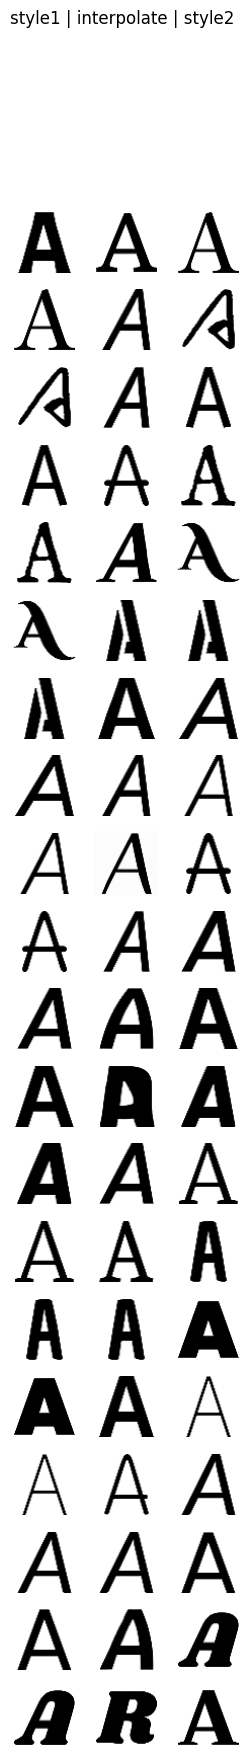

In [5]:
@torch.no_grad()
def p_sample_emb_interpolate(x, classes, style1, style2, t, t_index, class_scale=6., style_scale=6., rescaled_phi=0.7):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    pred_noise = model.emb_interpolate(x, t, classes, style1, style2, alpha=0.5)
    model_mean = sqrt_recip_alphas_t * (x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

style_scale = 3.
class_scale = 3.
rescaled_phi = 0.7

b = 20
img = torch.randn((b, channels, image_size, image_size), device=device)
classes = torch.full((b,), 0, device=device, dtype=torch.long)
style = torch.tensor([[i, (i+1)%num_style] for i in range(b)], device=device, dtype=torch.long)

for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
    img = p_sample_emb_interpolate(img, classes, style[:, 0], style[:, 1], torch.full((b,), i, device=device, dtype=torch.long), i,
                    class_scale=class_scale, style_scale=style_scale, rescaled_phi=rescaled_phi)

fig, ax = plt.subplots(b, 3, figsize=(3, b))
for i in range(b):
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
    ax[i, 2].axis('off')
    ax[i, 0].imshow(d[26*style[i][0]][0][0], cmap='gray')
    ax[i, 1].imshow(img[i][0].cpu().detach().clone(), cmap='gray')
    ax[i, 2].imshow(d[26*style[i][1]][0][0], cmap='gray')
fig.suptitle('style1 | interpolate | style2')
plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_emb_interpolate_{style_scale}_{class_scale}.png")

# reconstruction

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

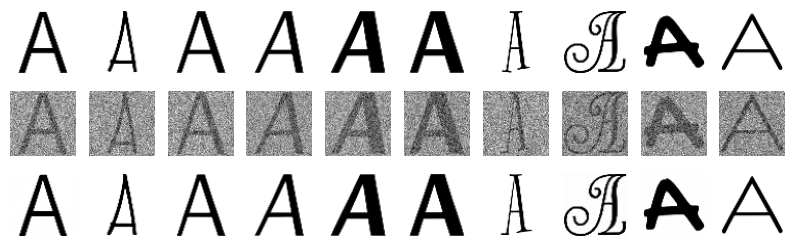

In [7]:
imgs = []
for i in range(10):
    imgs.append(d[26*i][0])
imgs = torch.stack(imgs).to(device)

sampling_t = int(0.5 * timesteps)
t = torch.full((10,), sampling_t, device=device, dtype=torch.long)
noisy_imgs = q_sample(imgs, t)

classes = torch.full((10,), 0, device=device, dtype=torch.long)
style = torch.tensor([i for i in range(10)], device=device, dtype=torch.long)
out = noisy_imgs
for i in tqdm(reversed(range(0, sampling_t)), desc='sampling loop time step', total=timesteps):
    out = p_sample(model, out, classes, style, torch.full((10,), i, device=device, dtype=torch.long), i,
                    class_scale=3., style_scale=3., rescaled_phi=.7)

fig, ax = plt.subplots(3, 10, figsize=(10, 3))
for i in range(imgs.shape[0]):
    ax[0, i].axis('off')
    ax[1, i].axis('off')
    ax[2, i].axis('off')
    ax[0, i].imshow(imgs[i][0].cpu().detach(), cmap='gray')
    ax[1, i].imshow(noisy_imgs[i][0].cpu().detach(), cmap='gray')
    ax[2, i].imshow(out[i][0].cpu().detach(), cmap='gray')

# ノイズの可視化

## style and class

In [9]:
# 同じノイズからの各クラスのノイズの方向

style_scale = 3.
class_scale = 3.
t_range = (int(0.90*timesteps), int(1.0*timesteps))
pca_path = f"./result/{os.path.basename(model_path).split('.')[0]}_styleclass1_PCA_time{t_range[0]}-{t_range[1]}.png"
pca_path2 = f"./result/{os.path.basename(model_path).split('.')[0]}_styleclass2_PCA_time{t_range[0]}-{t_range[1]}.png"

# 正規分布からノイズをサンプリング
noise_img = torch.randn_like(torch.zeros((1, 1, image_size, image_size)), device=device)

# # 実画像をノイズにしてサンプリング
# t = torch.full((1,), t_range[1]-1, device=device, dtype=torch.long)
# noise_img = q_sample(d[0][0].to(device), t).unsqueeze(0)

noise_img = torch.cat([noise_img for _ in range(128)], dim=0)
b = noise_img.shape[0]

target_class_num = 3
target_style_num = 3
noise_ave_list = [torch.zeros_like(noise_img).cpu().detach().clone() for _ in range(target_class_num*target_style_num)]
for c in range(target_class_num):
    for s in range(target_style_num):
        classes = torch.full((b,), c, device=device, dtype=torch.long)
        style = torch.full((b,), s, device=device, dtype=torch.long)
        x = noise_img
        with torch.no_grad():
            for i in tqdm(reversed(range(t_range[0], timesteps)), desc='sampling loop time step', total=timesteps): # 正規分布
            # for i in tqdm(reversed(range(t_range[0], t_range[1])), desc='sampling loop time step', total=timesteps): # 実画像
                t = torch.full((b,), i, device=device, dtype=torch.long)

                betas_t = extract(betas, t, x.shape)
                sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
                sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

                # ノイズ推定
                logits = model(x, t, classes, style, class_drop_prob=0., style_drop_prob=0.)
                style_null_logits = model(x, t, classes, style, class_drop_prob=0., style_drop_prob=1.)
                class_null_logits = model(x, t, classes, style, class_drop_prob=1., style_drop_prob=0.)
                pred_noise = logits + style_scale * (logits-style_null_logits) +  style_scale * (logits-class_null_logits)

                if t_range[0] <= i < t_range[1]:
                    noise_ave_list[c*target_style_num+s] += logits.cpu().detach().clone()

                model_mean = sqrt_recip_alphas_t * (x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

                if i == 0:
                    x = model_mean
                else:
                    posterior_variance_t = extract(posterior_variance, t, x.shape)
                    noise = torch.randn_like(x)
                    x = model_mean + torch.sqrt(posterior_variance_t) * noise

            noise_ave_list[c*target_style_num+s] = noise_ave_list[c*target_style_num+s] / (t_range[1] - t_range[0])

# pca
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(torch.cat(noise_ave_list, dim=0).reshape(b*target_class_num*target_style_num, -1).numpy())
print(pca.explained_variance_ratio_)
x = X_reduced[:,0]
y = X_reduced[:,1]

# class ごとに色を変える
plt.title('Coloring by class')
plt.scatter(x, y, c=[i//(b*target_style_num) for i in range(len(X_reduced))])
plt.savefig(pca_path)
plt.show()

# class ごとに色を変える
plt.title('Coloring by style')
plt.scatter(x, y, c=[(i//b)%target_class_num for i in range(len(X_reduced))])
plt.savefig(pca_path2)
plt.show()

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

## style

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

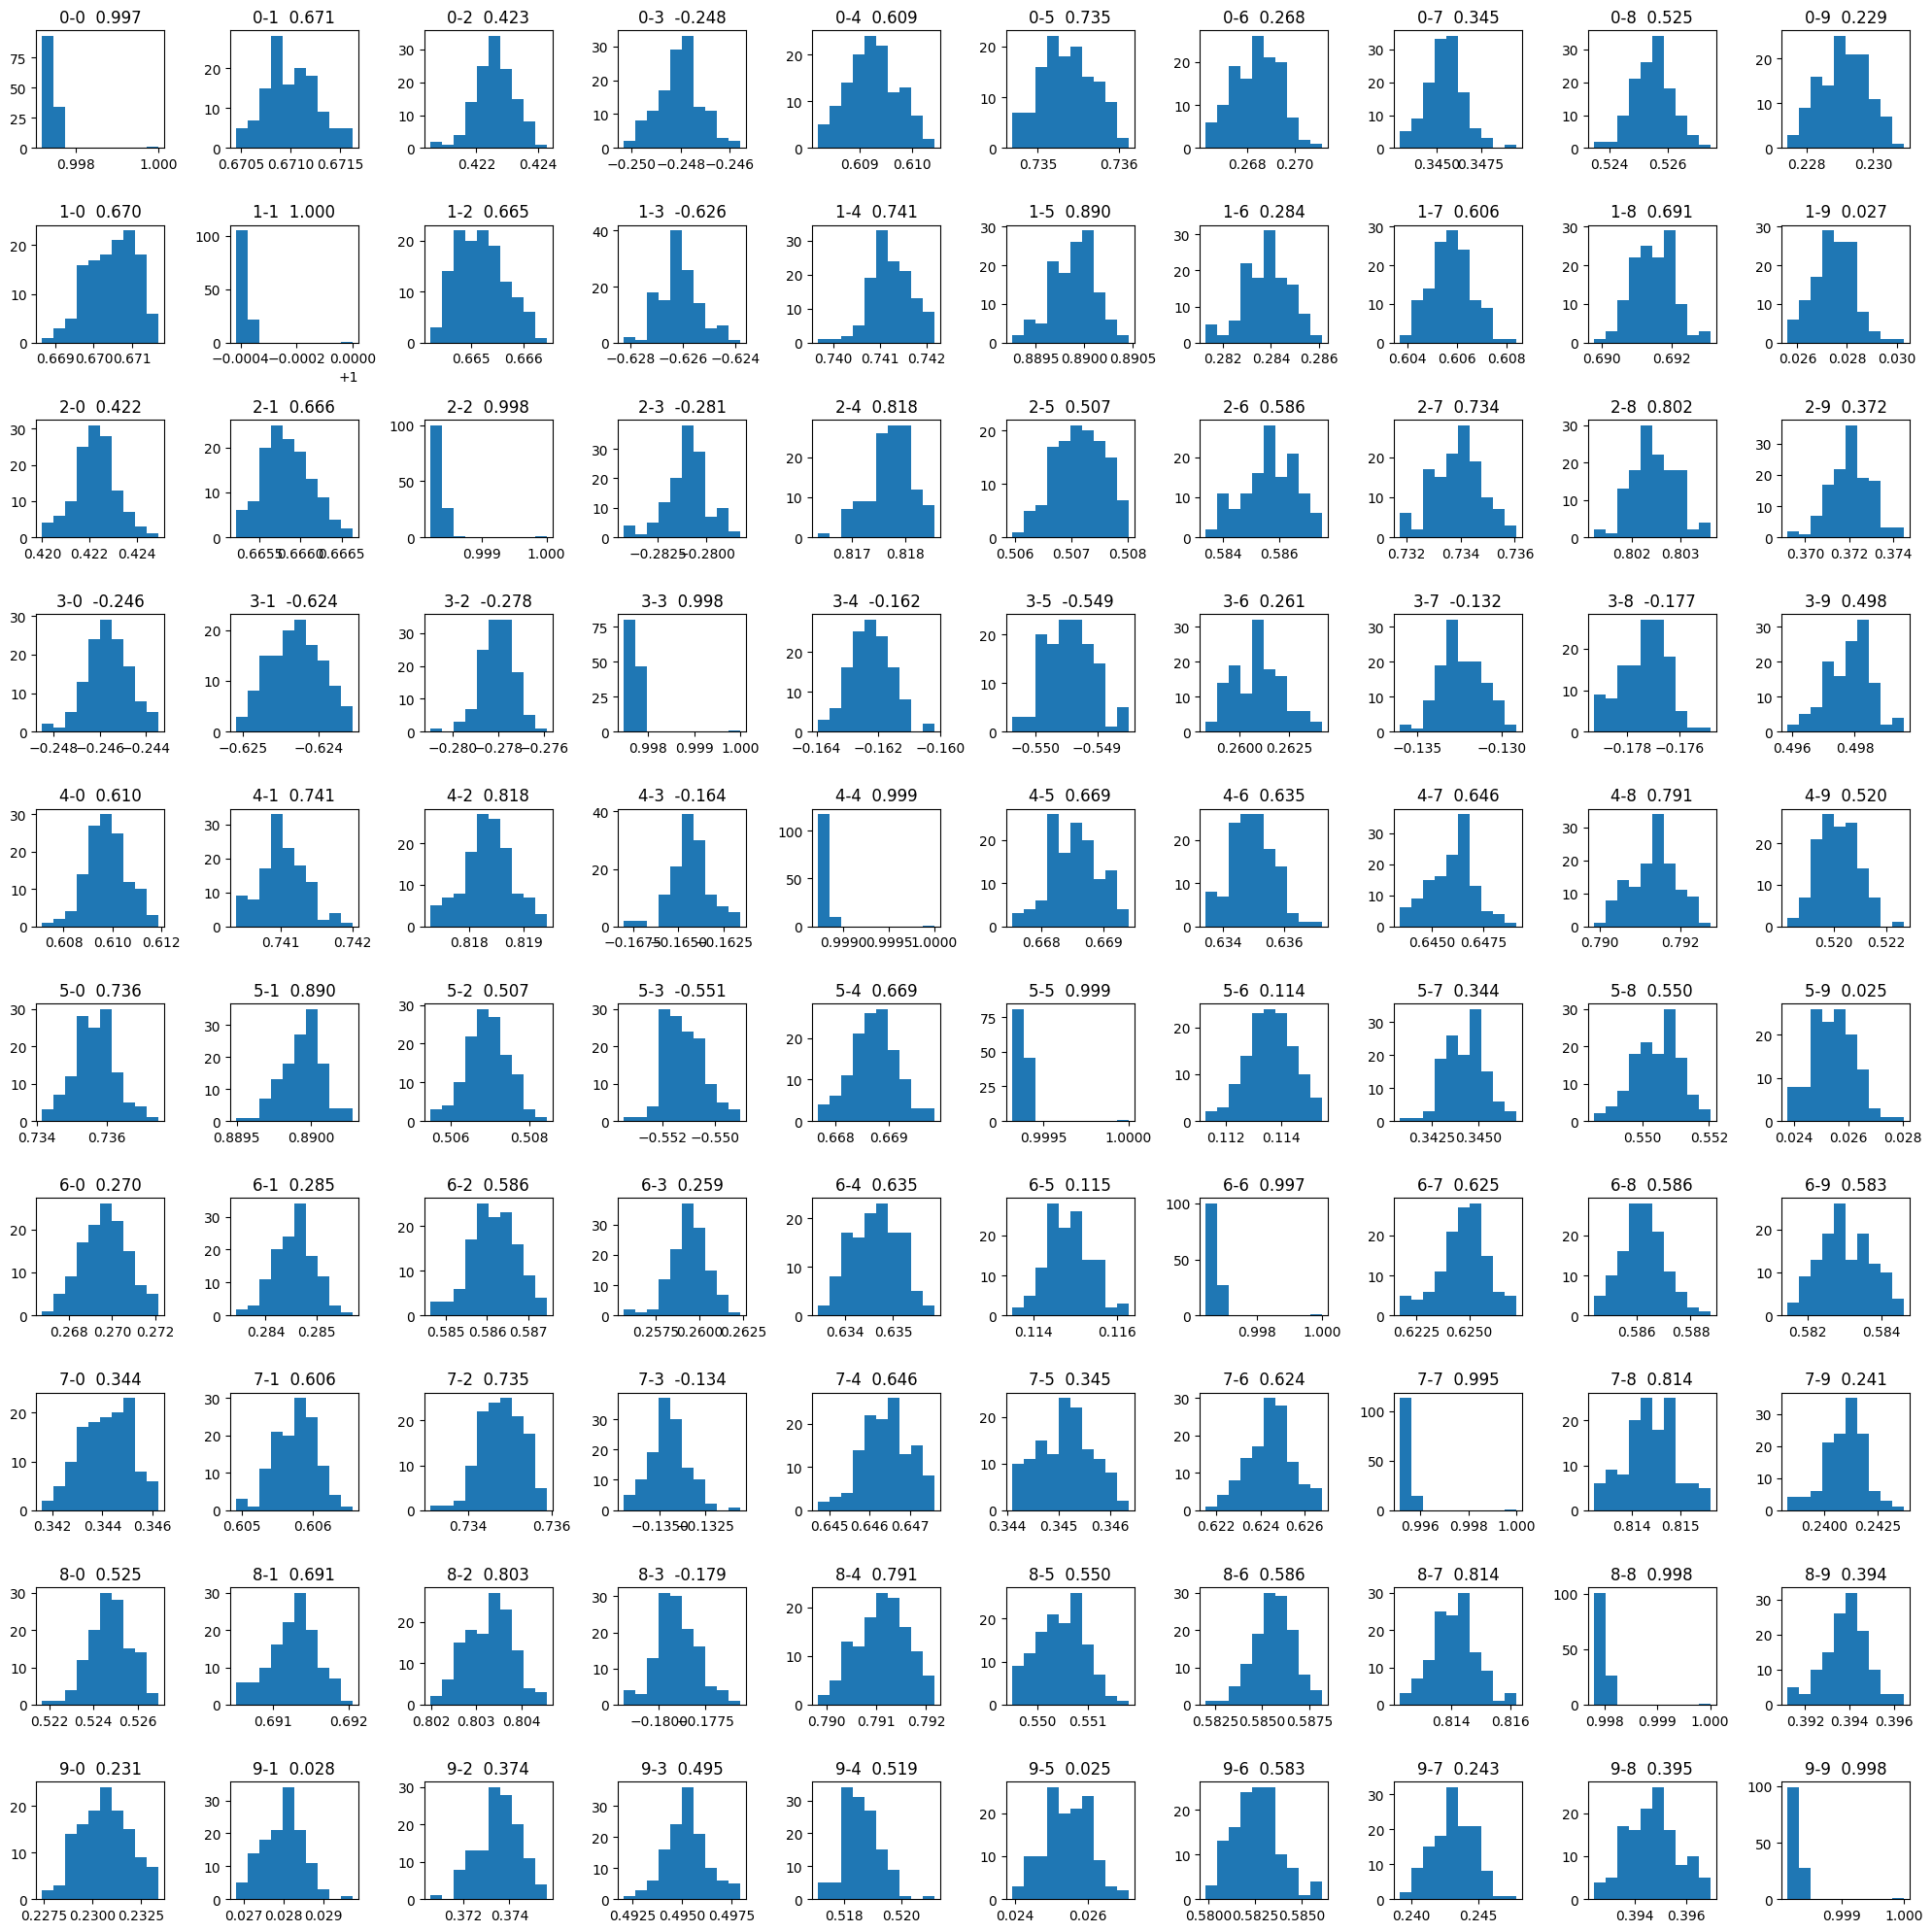

[0.6841188  0.11877615 0.07587676]


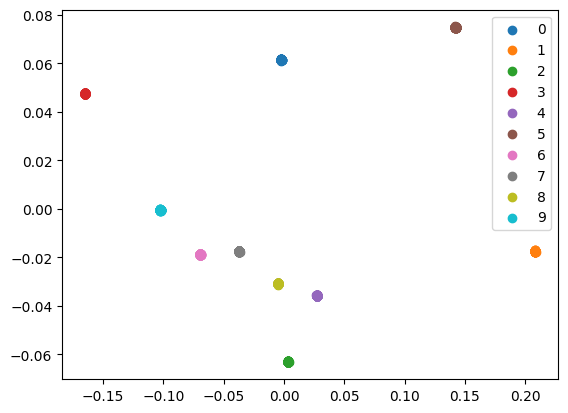

In [5]:
# 同じノイズからの各クラスのノイズの方向

target_style_num = 10
t_range = (int(0.9*timesteps), int(1.0*timesteps))
cos_sim_path = f"./result/{os.path.basename(model_path).split('.')[0]}_style_cos_sim_time{t_range[0]}-{t_range[1]}.png"
pca_path = f"./result/{os.path.basename(model_path).split('.')[0]}_style_PCA_time{t_range[0]}-{t_range[1]}.png"

noise_img = torch.randn_like(torch.zeros((1, 1, image_size, image_size)), device=device)
noise_img = torch.cat([noise_img for _ in range(128)], dim=0)
b = noise_img.shape[0]

noise_ave_list = [torch.zeros_like(noise_img).cpu().detach().clone() for i in range(target_style_num)]
for s in range(target_style_num):
    classes = torch.full((b,), 0, device=device, dtype=torch.long)
    style = torch.full((b,), s, device=device, dtype=torch.long)
    x = noise_img
    with torch.no_grad():
        for i in tqdm(reversed(range(t_range[0], timesteps)), desc='sampling loop time step', total=timesteps):
            t = torch.full((b,), i, device=device, dtype=torch.long)

            betas_t = extract(betas, t, x.shape)
            sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
            sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

            pred_noise = model(x, t, classes, style, class_drop_prob=1., style_drop_prob=0.) # for disentangle

            if t_range[0] <= i < t_range[1]:
                noise_ave_list[s] += pred_noise.cpu().detach().clone()

            model_mean = sqrt_recip_alphas_t * (x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

            if i == 0:
                x = model_mean
            else:
                posterior_variance_t = extract(posterior_variance, t, x.shape)
                noise = torch.randn_like(x)
                # Algorithm 2 line 4:
                x = model_mean + torch.sqrt(posterior_variance_t) * noise

        noise_ave_list[s] = noise_ave_list[s] / (t_range[1] - t_range[0])

# cosine similarity
cos_sim_list = [[] for _ in range(target_style_num)]
for source_i in range(target_style_num):
    for target_i in range(target_style_num):
        cos_sim_list[source_i].append(torch.nn.functional.cosine_similarity(noise_ave_list[source_i][0].reshape(-1), noise_ave_list[target_i].reshape(b, -1)))


fig, ax = plt.subplots(target_style_num, target_style_num, figsize=(20, 20))
for i in range(target_style_num):
    for j in range(target_style_num):
        ax[i, j].set_title(f"{i}-{j}  {cos_sim_list[i][j].mean():.3f}")
        ax[i, j].hist(cos_sim_list[i][j].cpu().detach().numpy())

plt.tight_layout()
plt.savefig(cos_sim_path)
plt.show()

# pca
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(torch.cat(noise_ave_list, dim=0).reshape(b*target_style_num, -1).numpy())
print(pca.explained_variance_ratio_)
x = X_reduced[:,0]
y = X_reduced[:,1]

for i in range(0, len(X_reduced), b):
    plt.scatter(x[i:i+b], y[i:i+b], label=i//b)
plt.legend()
plt.savefig(pca_path)
plt.show()

## class

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

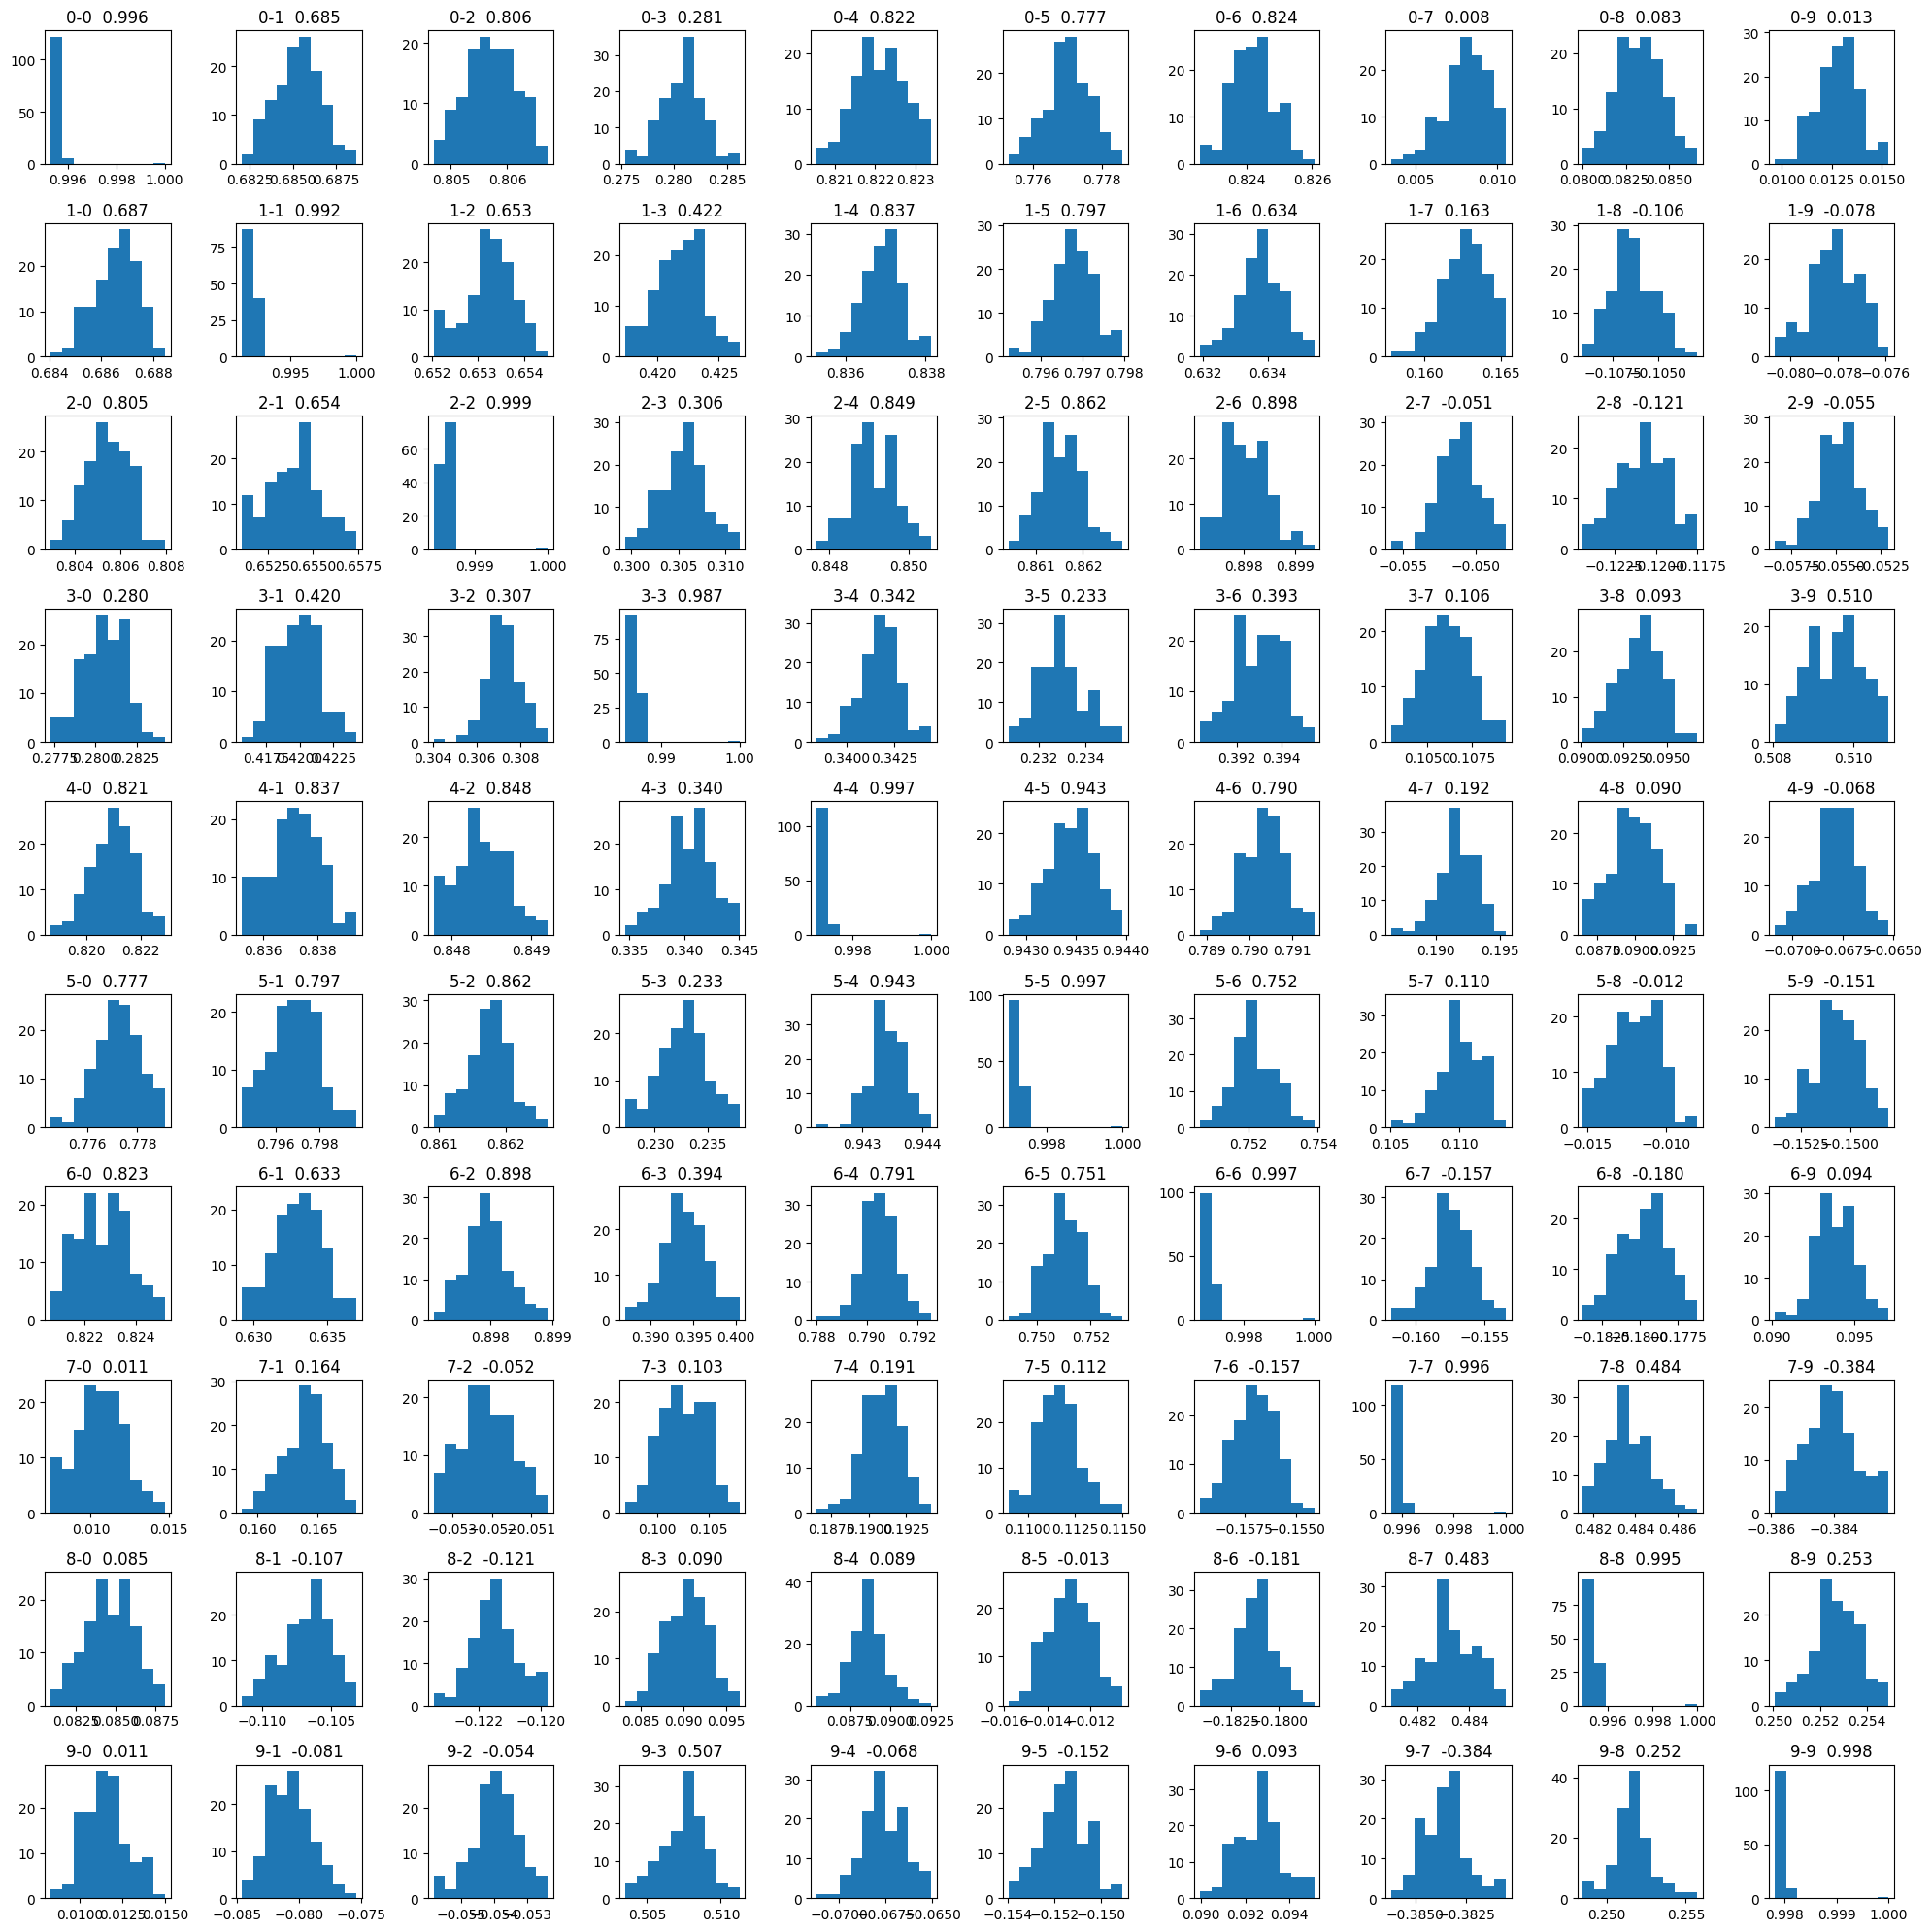

[0.5284471  0.27245915 0.06865548]


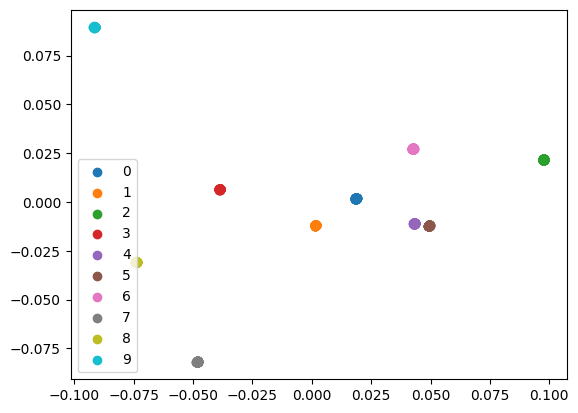

In [6]:
# 同じノイズからの各クラスのノイズの方向

t_range = (int(0.9*timesteps), int(1.0*timesteps))
target_class_num = 10
cos_sim_path = f"./result/{os.path.basename(model_path).split('.')[0]}_class-none_cos_sim_time{t_range[0]}-{t_range[1]}.png"
pca_path = f"./result/{os.path.basename(model_path).split('.')[0]}_class-none_PCA_time{t_range[0]}-{t_range[1]}.png"


noise_img = torch.randn_like(torch.zeros((1, 1, image_size, image_size)), device=device)
noise_img = torch.cat([noise_img for _ in range(128)], dim=0)
b = noise_img.shape[0]

noise_ave_list = [torch.zeros_like(noise_img).cpu().detach().clone() for i in range(target_class_num)]
for c in range(target_class_num):
    classes = torch.full((b,), c, device=device, dtype=torch.long)
    style = torch.full((b,), 0, device=device, dtype=torch.long)
    x = noise_img
    with torch.no_grad():
        for i in tqdm(reversed(range(t_range[0], timesteps)), desc='sampling loop time step', total=timesteps):
            t = torch.full((b,), i, device=device, dtype=torch.long)

            betas_t = extract(betas, t, x.shape)
            sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
            sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

            # pred_noise = model(x, t, classes, style, class_drop_prob=0., style_drop_prob=1.) # for disentangle
            class_noise = model(x, t, classes, style, class_drop_prob=0., style_drop_prob=1.)
            null_noise = model(x, t, classes, style, class_drop_prob=1., style_drop_prob=1.)
            pred_noise = class_noise - null_noise

            if t_range[0] <= i < t_range[1]:
                noise_ave_list[c] += pred_noise.cpu().detach().clone()

            model_mean = sqrt_recip_alphas_t * (x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

            if i == 0:
                x = model_mean
            else:
                posterior_variance_t = extract(posterior_variance, t, x.shape)
                noise = torch.randn_like(x)
                # Algorithm 2 line 4:
                x = model_mean + torch.sqrt(posterior_variance_t) * noise

        noise_ave_list[c] = noise_ave_list[c] / (t_range[1] - t_range[0])

# cosine similarity
cos_sim_list = [[] for _ in range(target_class_num)]
for source_i in range(target_class_num):
    for target_i in range(target_class_num):
        cos_sim_list[source_i].append(torch.nn.functional.cosine_similarity(noise_ave_list[source_i][0].reshape(-1), noise_ave_list[target_i].reshape(b, -1)))


fig, ax = plt.subplots(target_class_num, target_class_num, figsize=(20, 20))
for i in range(target_class_num):
    for j in range(target_class_num):
        ax[i, j].set_title(f"{i}-{j}  {cos_sim_list[i][j].mean():.3f}")
        ax[i, j].hist(cos_sim_list[i][j].cpu().detach().numpy())

plt.tight_layout()
plt.savefig(cos_sim_path)
plt.show()

# pca
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(torch.cat(noise_ave_list, dim=0).reshape(b*target_class_num, -1).numpy())
print(pca.explained_variance_ratio_)
x = X_reduced[:,0]
y = X_reduced[:,1]

for i in range(0, len(X_reduced), b):
    plt.scatter(x[i:i+b], y[i:i+b], label=i//b)
plt.legend()
plt.savefig(pca_path)
plt.show()

# スタイル/クラス埋め込みの可視化

[0.1040342  0.07266873 0.05411684]


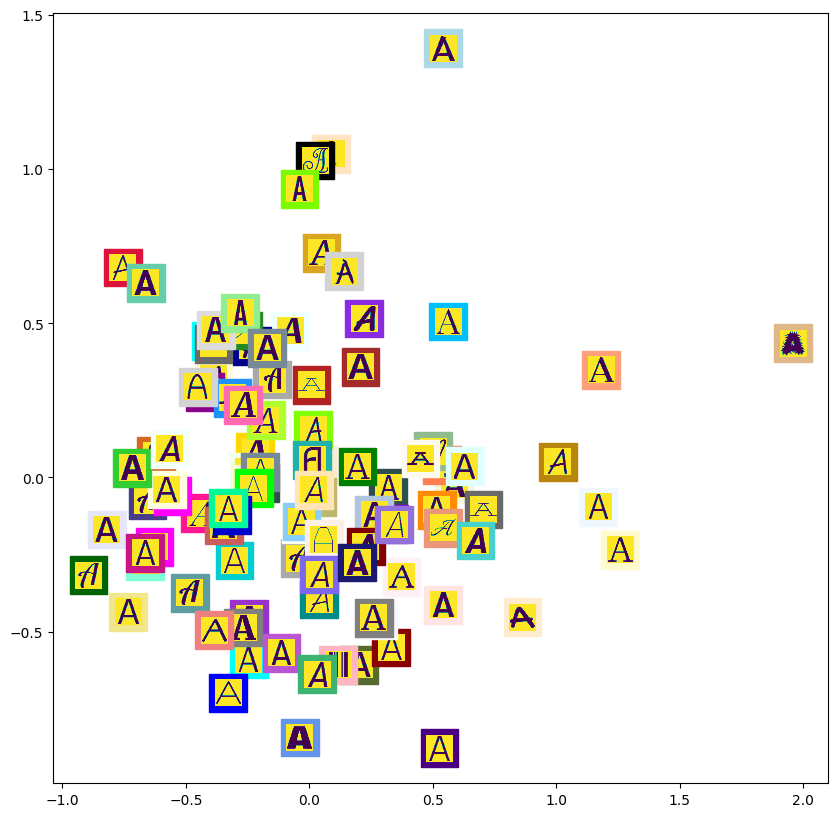

[0.10794472 0.09738914 0.09024908]


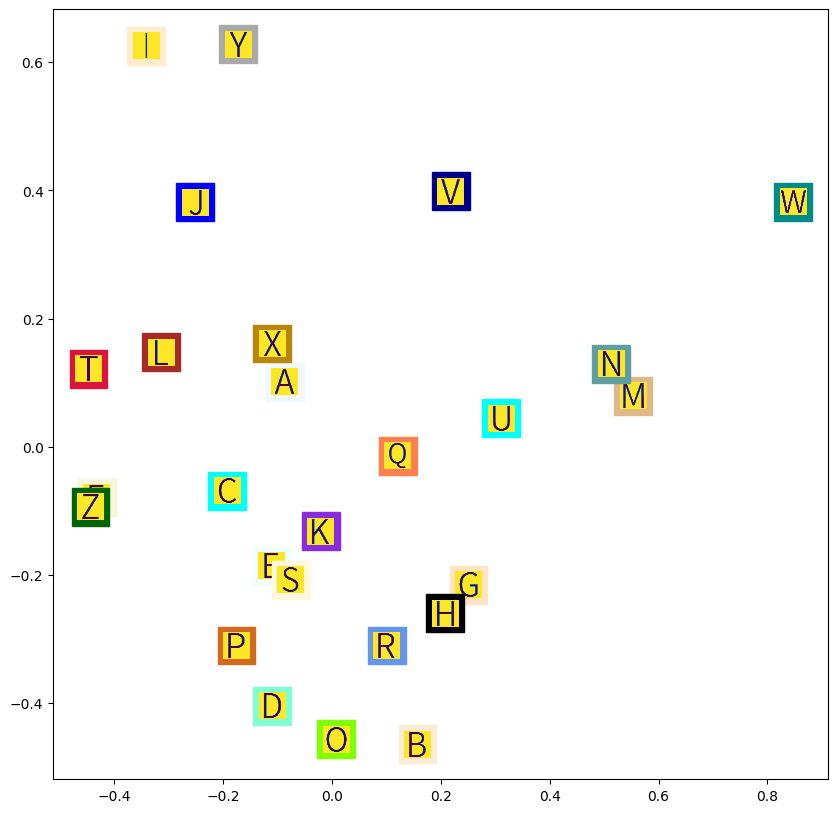

In [24]:
# style emb distribution
b = 100
color = list(matplotlib.colors.CSS4_COLORS.values())
classes = torch.full((b,), 0, device=device, dtype=torch.long)
style, img_list = [], []
for i in range(b):
    img_list.append(d[26*i][0][0])
    style.append(d[26*i][2])
style = torch.tensor(style, device=device, dtype=torch.long)
color_list = [color[s] for s in style]

style_emb = model.style_emb(style)
style_emb = model.style_mlp(style_emb)

pca = PCA(n_components=3)
X_reduced = pca.fit_transform(style_emb.cpu().detach().numpy())
print(pca.explained_variance_ratio_)
x = X_reduced[:,0]
y = X_reduced[:,1]

fig, ax = plt.subplots(figsize=(10,10))
imscatter(x, y, img_list, _ax=ax,zoom=0.3, color=color_list)
ax.plot(x,y,'ko',alpha=0.)
plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_style_emb_distribution.png")
plt.show()

# class emb distribution
b = 26
color = list(matplotlib.colors.CSS4_COLORS.values())
style = torch.full((b,), 0, device=device, dtype=torch.long)
classes, img_list = [], []
for i in range(b):
    img_list.append(d[i][0][0])
    classes.append(d[i][1])
classes = torch.tensor(classes, device=device, dtype=torch.long)
color_list = [color[c] for c in classes]

class_emb = model.classes_emb(classes)
class_emb = model.classes_mlp(class_emb)

pca = PCA(n_components=3)
X_reduced = pca.fit_transform(class_emb.cpu().detach().numpy())
print(pca.explained_variance_ratio_)
x = X_reduced[:,0]
y = X_reduced[:,1]

fig, ax = plt.subplots(figsize=(10,10))
imscatter(x, y, img_list, _ax=ax,zoom=0.3, color=color_list)
ax.plot(x,y,'ko',alpha=0.)
plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_classes_emb_distribution.png")
plt.show()

# 時刻ごとの diffusion loss

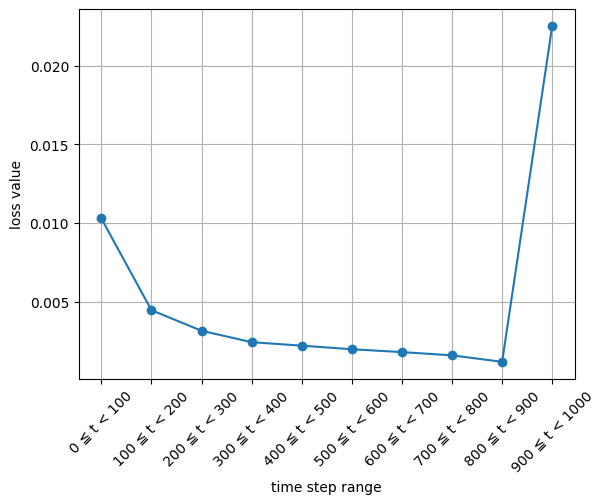

In [6]:
@torch.no_grad()
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

@torch.no_grad()
def p_losses(denoise_model, x_start, t, classes, style, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)

    # ordinal diffusion loss
    predicted_noise = denoise_model(x_noisy, t, classes, style)

    b = x_noisy.size(0)
    diff_loss = F.smooth_l1_loss(noise.view(b, -1), predicted_noise.view(b, -1), reduction='none').mean(dim=1)

    return diff_loss

visualize_t = [i for i in range(100, timesteps+1, 100)]
loss_list = [[] for _ in range(10)]

for batch, classes, style in dataloader:
    batch = batch.to(device)
    classes = classes.to(device)
    style = style.to(device)

    t = torch.randint(0, timesteps, (batch.size(0),), device=device, dtype=torch.long)

    diff_loss = p_losses(model, batch, t, classes, style)

    for i in range(t.size(0)):
        for j in range(10):
            if t[i].item() < visualize_t[j]:
                loss_list[j].append(diff_loss[i].item())
                break

mean_loss_list = [sum(loss_list[i])/len(loss_list[i]) for i in range(10)]

plt.figure()
plt.plot(mean_loss_list, marker='o')
plt.xticks([i for i in range(10)],
        [f"{visualize_t[i]-100} ≦ t < {visualize_t[i]}" for i in range(10)],
        rotation=45)
plt.xlabel('time step range')
plt.ylabel('loss value')
plt.grid()
plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_loss_at_different_times.png", bbox_inches='tight')
plt.show()